For reproducibility reasons, we set the NumPy random seed and the TensorFlow random seed.

In [1]:
random_seed_numpy = 1
random_seed_tensorflow = 2

In [2]:
from numpy.random import seed
seed(random_seed_numpy)
import tensorflow as tf
tf.random.set_seed(random_seed_tensorflow)

In [10]:
import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re

from IPython.display import Image
from lime import lime_image
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, PReLU
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.vanilla_gradients import VanillaGradients
from random import choice, randint
from sklearn.preprocessing import MultiLabelBinarizer

In [4]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="xai-research-project")

W&B Run: https://app.wandb.ai/davethephysicist/xai-research-project/runs/2lhtps9i

In [5]:
wandb.config.random_seed_numpy = random_seed_numpy
wandb.config.random_seed_tensorflow = random_seed_tensorflow

D:\Anaconda\envs\xai-rp\lib\site-packages\wandb\compat\tempfile.py:64: UserWarning: Couldn't remove temp directory C:\Users\cian_\AppData\Local\Temp\tmpk4xw3rjowandb
  _warnings.warn("Couldn't remove temp directory %s" % name)


Usually, for multi-label classification problems, the binary cross-entropy loss function is used. However, when the labels are encoded using a multilabel binarizer and the target has on average only a small fraction of the possible labels, a network will very easily learn to predict no labels to minimize BCE. To circumvent this, we define our own BCE with logits, where we additionally weigh false negatives (type II errors) more than false positives (type I errors). 

In [42]:
POS_WEIGHT = 16

wandb.config.loss_pos_weight = POS_WEIGHT

def weighted_binary_cross_entropy(target, output):
    _epsilon = tf.keras.backend.cast(tf.keras.backend.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output_logit = tf.math.log(output / (1 - output))
    
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=output_logit, pos_weight=POS_WEIGHT)
    
    return tf.reduce_mean(loss, axis=-1)

In [7]:
box_11002_real_file_path = "Boxes/box-11002-real-dataset.csv"
box_11002_real = pd.read_csv(box_11002_real_file_path, dtype={'Brick': 'string'})
box_11002_file_path = "Boxes/box-11002.csv"
box_11002 = pd.read_csv(box_11002_file_path, dtype={'Brick': 'string'})
brick_classes = box_11002.Brick
num_classes = brick_classes.size

We use a multilabel binarizer to encode the labels. This means that we have one column per brick, where a 0 denotes the absence of the brick and a 1 denotes its presence.

In [8]:
brick_labels_binarizer = MultiLabelBinarizer(classes=brick_classes)
brick_labels_binarizer = brick_labels_binarizer.fit(None)

In [9]:
synthetic_dataset_path = "../synthetic-dataset-dc"
real_dataset_path = "../real-dataset-dc"

We use a generator for two reasons. First, this allows us to save memory. Second, it allows us use on-the-fly data augmentation.

In [11]:
def image_generator(dataset_paths, batch_size, image_dims):
    images_folder_paths = [dataset_path + "/Renders" for dataset_path in dataset_paths]
    sets_file_paths = [dataset_path + "/Sets/brick_sets.csv" for dataset_path in dataset_paths]
    
    while True: 
        selected_dataset_idx = randint(0, len(dataset_paths) - 1)
        images_folder_path = images_folder_paths[selected_dataset_idx]
        sets_file_path = sets_file_paths[selected_dataset_idx]
        
        # Retrieve image entries as list instead of iterator, for subsequent sampling
        image_entries = os.listdir(images_folder_path)
        brick_sets_file = open(sets_file_path, "r")
        brick_sets = brick_sets_file.readlines()
        
        batch_images = []
        batch_labels = []
        for _ in range(batch_size):
            # Pick a random image
            image_name = choice(image_entries)
            image_idx = int(re.search("\d{1,5}", image_name).group())
            # Read the image file to a numpy array
            image = cv2.imread(images_folder_path + "/" + image_name)
            # Resize the image
            image = cv2.resize(image, image_dims)
            # Add the image to the batch of images
            batch_images.append(image)
            # Add the labels to the batch labels
            brick_set = brick_sets[image_idx].rstrip().split(",")
            batch_labels.append(brick_set)
        
        # Concatenate the list of images into a single numpy array
        batch_images = np.stack(batch_images).astype('float32') / 255.0
        # Encode the brick labels using a multi label binarizer
        batch_labels = brick_labels_binarizer.transform(batch_labels)
        batch_labels = batch_labels.astype('float32')
            
        yield batch_images, batch_labels

In [12]:
synthetic_dataset_paths = [entry.path for entry in os.scandir(synthetic_dataset_path)]
real_dataset_paths = [real_dataset_path + "/" + dataset_name for dataset_name in ['batch_berend', 'batch_david']]
dataset_paths = real_dataset_paths

In [13]:
image_size = (360, 240)

wandb.config.image_size = image_size

test_img_generator = image_generator(dataset_paths, 10, image_size)
test_images, test_labels = next(test_img_generator)

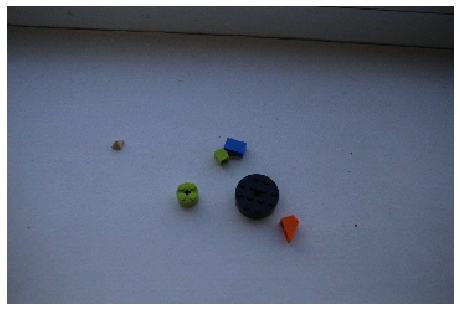

In [14]:
test_image = test_images[0]
plt.figure(figsize=(8,6))
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
model_architecture_path = "model_architecture.json"
model_weights_path = "model_weights.h5"

In [35]:
# WARNING: RUN ONLY IF YOU WANT TO LOAD PRE-EXISTING MODEL
model_architecture_file = open(model_architecture_path, "r")
model_architecture_json = model_architecture_file.read()
model_architecture_file.close()

# Load the architecture
loaded_model = model_from_json(model_architecture_json)

# Load the weights
loaded_model.load_weights(model_weights_path)

print(f"Loaded model with architecture file {model_architecture_path} and weights file {model_weights_path}")

Loaded model with architecture file model_architecture.json and weights file model_weights.h5


In [ ]:
# WARNING: RUN ONLY IF YOU WANT TO USE A NEW MODEL
model1 = Sequential()
model1.add(Conv2D(128, (3, 3), name="first_convolutional_layer", input_shape=(image_size[1], image_size[0], 3)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128, (3, 3), name="conv_layer_2"))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(128, (3, 3), name="conv_layer_3"))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3), name="conv_layer_4"))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3), name="last_convolutional_layer"))
model1.add(BatchNormalization())
model1.add(Activation('relu', name="last_convolutional_layer_act"))
model1.add(Flatten(name="classifier_layer_2"))
model1.add(Dense(64, name="classifier_layer_3"))
model1.add(Activation('relu', name="classifier_layer_4"))
model1.add(Dense(128, name="classifier_layer_5"))
model1.add(Activation('relu', name="classifier_layer_6"))
model1.add(Dense(num_classes, name="classifier_layer_7"))
model1.add(Activation('sigmoid'))

In [44]:
# WARNING: RUN ONLY IF YOU WANT TO USE XCEPTION WITH TRANSFER LEARNING
input_tensor = Input(shape=(image_size[1], image_size[0], 3))

base_model_xception = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = base_model_xception.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
xception_predictions = Dense(num_classes, activation='sigmoid')(x)

xception_model = Model(base_model_xception.input, xception_predictions)

for layer in base_model_xception.layers:
    layer.trainable = False
    
LEARNING_RATE = 0.01

wandb.config.learning_rate = LEARNING_RATE

optimizer = Adam(learning_rate=LEARNING_RATE)
    
xception_model.compile(optimizer=optimizer, loss=weighted_binary_cross_entropy, metrics=['binary_accuracy'])

BATCH_SIZE = 8
NUM_EPOCHS = 3

wandb.config.batch_size = BATCH_SIZE
wandb.config.num_epochs = NUM_EPOCHS

image_generator_1 = image_generator(dataset_paths, BATCH_SIZE, image_size)
num_images = sum([len(os.listdir(path + "/Renders")) for path in dataset_paths])
steps_per_epoch = num_images // BATCH_SIZE

training_history = xception_model.fit(image_generator_1, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, callbacks=[WandbCallback()])

  ...
    to  
  ['...']
Train for 203 steps
Epoch 1/3
203/203 [==============================] - 1668s 8s/step - loss: 12.1711 - binary_accuracy: 0.8543
Epoch 2/3
203/203 [==============================] - 649s 3s/step - loss: 12.0402 - binary_accuracy: 0.8601
Epoch 3/3
203/203 [==============================] - 641s 3s/step - loss: 12.2959 - binary_accuracy: 0.8592


In [45]:
for i, layer in enumerate(base_model_xception.layers):
    print(i, layer.name)

0 input_13
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_48
13 block2_pool
14 batch_normalization_48
15 add_144
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_49
23 block3_pool
24 batch_normalization_49
25 add_145
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_50
33 block4_pool
34 batch_normalization_50
35 add_146
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_147
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
5

In [50]:
for layer in xception_model.layers[:96]:
    layer.trainable = False
for layer in xception_model.layers[96:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(learning_rate=0.0001)
xception_model.compile(optimizer=optimizer, loss=weighted_binary_cross_entropy, metrics=['binary_accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
training_history = xception_model.fit(image_generator_1, steps_per_epoch=steps_per_epoch, epochs=1, callbacks=[WandbCallback()])

  ...
    to  
  ['...']
Train for 203 steps
203/203 [==============================] - 623s 3s/step - loss: 12.4213 - binary_accuracy: 0.8585


In [51]:
top_level_model = xception_model
top_level_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 240, 360, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 179, 32) 864         input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 179, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 179, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [39]:
LEARNING_RATE = 0.001

#wandb.config.learning_rate = LEARNING_RATE

optimizer = Adam(learning_rate=LEARNING_RATE)
top_level_model.compile(optimizer=optimizer, loss=weighted_binary_cross_entropy, metrics=['binary_accuracy'])

<class 'tensorflow.python.framework.ops.Tensor'>
Target shape: (None, None); logits shape: (None, 85)


In [40]:
BATCH_SIZE = 8
NUM_EPOCHS = 4

#wandb.config.batch_size = BATCH_SIZE
#wandb.config.num_epochs = NUM_EPOCHS

image_generator_1 = image_generator(dataset_paths, BATCH_SIZE, image_size)
num_images = sum([len(os.listdir(path + "/Renders")) for path in dataset_paths])
steps_per_epoch = num_images // BATCH_SIZE
training_history = top_level_model.fit(image_generator_1, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, callbacks=[WandbCallback()])

  ...
    to  
  ['...']
Train for 203 steps
Epoch 1/4
<class 'tensorflow.python.framework.ops.Tensor'>
Target shape: (None, None); logits shape: (None, 85)
<class 'tensorflow.python.framework.ops.Tensor'>
Target shape: (None, None); logits shape: (None, 85)
  1/203 [..............................] - ETA: 1:43:17

KeyboardInterrupt: 

In [ ]:
model_architecture_json = top_level_model.to_json()

# Save the model architecture in JSON format
with open(model_architecture_path, "w") as model_architecture_file:
    model_architecture_file.write(model_architecture_json)
    
# Save the model weights in HDF5 format
top_level_model.save_weights(model_weights_path)
print(f"Model weights have been saved to {model_weights_path}")

top_level_model.save(os.path.join(wandb.run.dir, "full_model.h5"))

In [ ]:
plt.plot(training_history.history['loss'], label='train_loss')
plt.plot(training_history.history['binary_accuracy'], label='train_acc')

In [ ]:
history_path = "history"

with open(history_path, "wb") as history_file:
    pickle.dump(training_history.history, history_file)

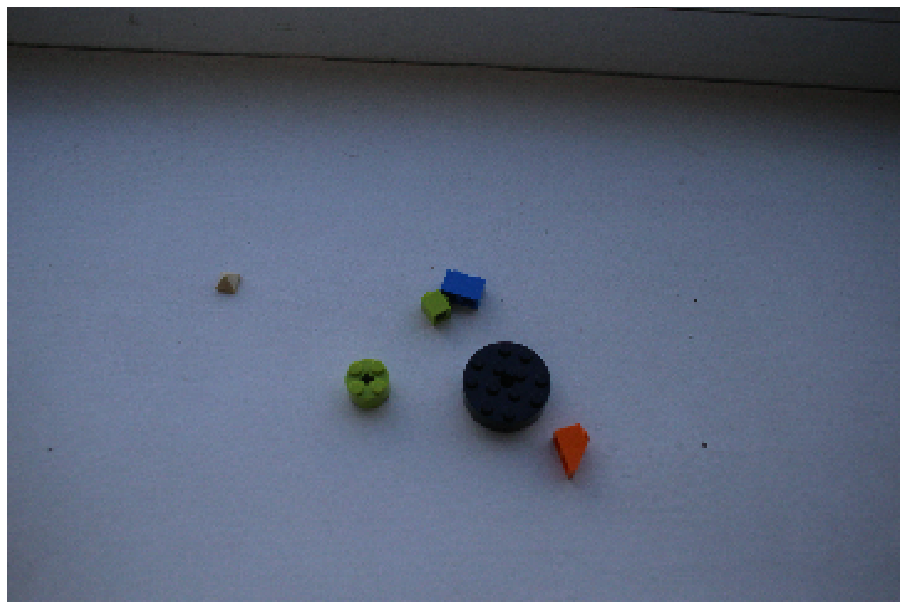

Predicted: {'306201': 1.0, '306223': 1.0, '300424': 1.0, '4153825': 1.0, '6022064': 1.0, '4211614': 1.0, '4621545': 1.0, '6004938': 1.0, '6151663': 1.0, '4504369': 0.0, '300401': 0.0, '365901': 0.0, '4160403': 0.0, '6249125': 0.0, '4118793': 0.0, '4109995': 0.0, '4114319': 0.0, '4181134': 0.0, '4157124': 0.0, '614321': 0.0, '300421': 0.0, '300321': 0.0, '300121': 0.0, '300821': 0.0, '4651236': 0.0, '300423': 0.0, '300323': 0.0, '300123': 0.0, '4639693': 0.0, '4504381': 0.0, '4550348': 0.0, '623224': 0.0, '300124': 0.0, '654126': 0.0, '4548180': 0.0, '6138173': 0.0, '4558957': 0.0, '4181144': 0.0, '4181135': 0.0, '4647553': 0.0, '4143562': 0.0, '6074890': 0.0, '6069259': 0.0, '6244886': 0.0, '6238674': 0.0, '6223631': 0.0, '4121739': 0.0, '4121967': 0.0, '4153827': 0.0, '4212454': 0.0, '6073026': 0.0, '6025026': 0.0, '4527943': 0.0, '4650630': 0.0, '4165967': 0.0, '6252809': 0.0, '6003007': 0.0, '4539099': 0.0, '4567338': 0.0, '6062574': 0.0, '6035291': 0.0, '4211166': 0.0, '4211149': 0

In [52]:
plt.figure(figsize=(16,12))
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

prediction = top_level_model.predict(np.expand_dims(test_image, axis=0))
prediction = pd.DataFrame(prediction, columns=brick_labels_binarizer.classes_)

top_ten = {column: prediction.loc[0, column] for column in prediction.columns}
top_ten = {k: v for k, v in sorted(top_ten.items(), key=lambda item: item[1], reverse=True)}
print("Predicted: " + str(top_ten))

print("Actual: " + str(brick_labels_binarizer.inverse_transform(test_labels)[0]))

print("Predicted probability for actual: " + str({brick_code: top_ten[brick_code] for brick_code in brick_labels_binarizer.inverse_transform(test_labels)[0]}))

In [53]:
def show_convolution_kernels_rgb(model, layer_name, first_n):
    filters, biases = top_level_model.get_layer(layer_name).get_weights()

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters, ix = 10, 1

    for i in range(n_filters):
        f = filters[:,:,:,i]
        ax = plt.subplot(n_filters, 1, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :])
        ix += 1
            
    plt.show()

In [54]:
def show_convolution_kernels(model, layer_name, first_n=1, n_channels=1):
    filters, biases = top_level_model.get_layer(layer_name).get_weights()

    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters, ix = first_n, 1
    
    if n_channels == 0:
        n_channels = filters.shape[-1]

    for i in range(n_filters):
        f = filters[:,:,:,i]
        for j in range(n_channels):
            ax = plt.subplot(n_filters, n_channels, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
            
    plt.show()

In [55]:
show_convolution_kernels_rgb(top_level_model, "first_convolutional_layer", 8)

for layer_name in ["conv_layer_2", "conv_layer_3", "conv_layer_4", "last_convolutional_layer"]:
    print(f"Layer {layer_name}")
    show_convolution_kernels(top_level_model, layer_name, first_n=4, n_channels=4)

ValueError: No such layer: first_convolutional_layer

In [ ]:
def show_feature_map(model, layer_name):
    # Model that maps input to last conv layer
    target_layer = model.get_layer(layer_name)
    target_layer_model = Model(model.inputs, target_layer.output)

    # Convert image from numpy array to tensor
    test_image_expanded = np.expand_dims(test_image, axis=0)

    feature_maps = target_layer_model.predict(test_image_expanded)

    square_length = 4
    ix = 1
    for _ in range(square_length):
        for _ in range(square_length):
            ax = plt.subplot(square_length, square_length, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

In [ ]:
target_layer = top_level_model.get_layer(layer_name)
target_layer_model = Model(top_level_model.inputs, target_layer.output)
test_image_expanded = np.expand_dims(test_image, axis=0)
feature_maps = target_layer_model.predict(test_image_expanded)

print(feature_maps[0, :, :, 0])

In [ ]:
for layer_name in ["first_convolutional_layer", "conv_layer_2", "conv_layer_3", "conv_layer_4", "last_convolutional_layer"]:
    print(f"Layer {layer_name}")
    show_feature_map(top_level_model, layer_name)

Occlusion sensitivity consists in measuring the impact of occluding (removing) parts of the input image on the score obtained for a class. Parts which improve the score are considered hot, parts that do not are considered cold. The image is divided into grids, and each cell is removed individually, after which the network is run on the modified input. A heatmap is constructed from the results

In [ ]:
occlusion_sensitivity_explainer = OcclusionSensitivity()

test_data = ([test_image], None)

grid = occlusion_sensitivity_explainer.explain(test_data, top_level_model, 0, 10)

occlusion_sensitivity_explainer.save(grid, ".", "occlusion_sensitivity_tf_explain.png")

In [ ]:
vanilla_gradients_explainer = VanillaGradients()

test_data = (np.expand_dims(test_image, axis=0), None)

grid = vanilla_gradients_explainer.explain(test_data, top_level_model, 0)

vanilla_gradients_explainer.save(grid, ".", "vanilla_gradients_tf_explain.png")

In [ ]:
integrated_gradients_explainer = IntegratedGradients()

test_data = (np.expand_dims(test_image, axis=0), None)

grid = integrated_gradients_explainer.explain(test_data, top_level_model, 0)

integrated_gradients_explainer.save(grid, ".", "integrated_gradients_tf_explain.png")

In [56]:
# For some reason, doesn't work, and is quite wonky on top of that
# TODO: use latest version from GitHub instead of PyPI, to turn off guided gradients
explainer = GradCAM()

test_data = ([test_image], None)

grid = explainer.explain(test_data, top_level_model, 1, layer_name = "last_convolutional_layer")

explainer.save(grid, ".", "grad_cam_tf_explain.png")

D:\Anaconda\envs\xai-rp\lib\site-packages\tf_explain\utils\display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


In [57]:
def grad_cam(model, image, last_conv_layer_name, classifier_layer_names, top_idx):   
    # Convert image from numpy array to tensor
    image = np.expand_dims(image, axis=0)
    
    # Model that maps input to last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)
    
    # Model that maps last_conv layer to output
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)
    
    # Compute gradient of best scored brick with respect to last conv layer activation
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(image)
        tape.watch(last_conv_layer_output)
        # Compute predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = (tf.argsort(preds[0])[::-1])[top_idx]
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    # GAP (global average pool) the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weigh activation maps by importance
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        #print(f"Max on convolution {i}: {np.max(last_conv_layer_output[:, :, i])}")
        #print(f"Min on convolution {i}: {np.min(last_conv_layer_output[:, :, i])}")
        #print(f"Coefficient on convolution {i}: {pooled_grads[i]}")
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        #print(f"Result of mul: {last_conv_layer_output[:, :, i]}")
    
    # Compute the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)
       
    # Normalize the heatmap for visualization purposes
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    brick_code = brick_labels_binarizer.classes_[top_pred_index]
    brick_score = preds[0][top_pred_index]
    
    return heatmap, brick_code, brick_score

In [ ]:
model, last_conv_layer = top_level_model, "last_convolutional_layer"
classifier_layer_names = ["classifier_layer_2", "classifier_layer_3", "classifier_layer_4", 
                          "classifier_layer_5", "classifier_layer_6", "classifier_layer_7"]

heatmaps = []
brick_codes = []
brick_scores = []

for i in range(num_classes):
    heatmap, brick_code, brick_score = grad_cam(model, test_image, last_conv_layer, classifier_layer_names, i)
    heatmaps.append(heatmap)
    brick_codes.append(brick_code)
    brick_scores.append(brick_score)

In [ ]:
for i in range(num_classes):
    print(f"Gradcam for brick code {brick_codes[i]} (score {brick_scores[i]})")
    plt.matshow(heatmaps[i])
    plt.show()

In [ ]:
top_idx = 0

# Rescale the heatmap
heatmap = np.uint8(255 * heatmaps[top_idx])

# Use the jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((test_image.shape[1], test_image.shape[0]))
jet_heatmap = img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.001 + cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
superimposed_img = array_to_img(superimposed_img)

# Save the superimposed image
save_path = "test_grad_cam.jpg"
superimposed_img.save(save_path)

# Display test image again
plt.axis('off')
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()

# Display Grad CAM
display(Image(save_path))

print("Brick code: {}, with score {}".format(brick_codes[top_idx], brick_scores[top_idx]))

In [ ]:
help(lime_image.LimeImageExplainer.explain_instance)

In [ ]:
lime_explainer = lime_image.LimeImageExplainer()

explanation = lime_explainer.explain_instance(test_image.astype('double'), top_level_model.predict, top_labels=20, hide_color=0, num_samples=1000)

In [ ]:
from skimage.segmentation import mark_boundaries

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))